# Sentiment Analysis in IMDb Reviews

This notebook is inspired from here: https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks

## Import libraries

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from keras.datasets import imdb 
from keras.models import Sequential 
from keras.layers import Dense, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils, plot_model

## Import data

We chose to classify IMDB reviews as positive or negative. An IMDB sample is available in the Keras datasets library.

In [17]:
# Fix random seed for reproducibility 
np.random.seed(7) 

# Load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

The data has been pre-processed. All words were mapped to integers representing the indexes of the words sorted by their frequency in the IMDB reviews. Integers 0, 1 and 2 are reserved for padding, the start marker and an unknown word.

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_train[:2])   # print first 2 train samples
print(y_train[:2])   # print first 2 target samples

(25000,)
(25000,)
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32])
 list([1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 

In order to peek at the reviews and see what people have written, the process can be reversed:

In [23]:
INDEX_FROM = 3   # word index offset
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
print(len(word_to_id))
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

88584
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for wha

## Preprocess data

Reviews can have different lengths, but need to have a same common lenth in order to feed the LSTM. Let us set this length to 500. If reviews have more than 500 words, they will be trimmed to these first 500 words. If they have less than 500 words, they will be padded with zeros. Keras offers a set of preprocessing routines which can do this.

In [24]:
# Truncate and pad the review sequences 
max_review_length = 500 
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

Here, the output padded array was represented as a Pandas dataframe for a better visualization. Lots of reviews have padded 0 at the beggining, meaning that they are shorter than 500 words.

In [25]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,4472,113,103,32,15,16,2,19,178,32
1,0,0,0,0,0,0,0,0,0,0,...,52,154,462,33,89,78,285,16,145,95
2,0,0,0,0,0,0,0,0,0,0,...,106,607,624,35,534,6,227,7,129,113
3,687,23,4,2,2,6,3693,42,38,39,...,26,49,2,15,566,30,579,21,64,2574
4,0,0,0,0,0,0,0,0,0,0,...,19,14,5,2,6,226,251,7,61,113


## Create model

Now we can build a sequential model.

1. An embedding layer, which will learn a word embedding for all the words of the dataset. It has 3 arguments: (1) the input dimension, i.e. the size of the vocabulary (in our case the 5000 top words), (2) the output dimension, i.e. the dimension of the vector space in which words will be embedded (in our case, we set it to 32), and (3) the input length, i.e. the length of input sequences, namely the reviews (in our case, we set it to 500). Pre-trained word embeddings, such as GloVE or [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html), are also available if you don't want to train your embeddings by yourself. So, the output of the embedding layer is a 500 x 32 matrix.

2. An LSTM layer with 100 memory units. Remember that LSTM are a specific type of RNN capable of learning relationships between elements in input sequences. In our case, the elements are words and the sequences are reviews. 

3. A dense layer with one node and with a sigmoid activation as the output.

Since the decision is binary, i.e. the review can be either positive or negative, the binary_crossentropy is used for the loss function. The optimizer is the standard one (adam) and the metrics are also the standard accuracy metric.

In [38]:
# Create the model 
embedding_vector_length = 32 

model = Sequential() 
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
model.add(LSTM(100)) 
# The sentiment analysis will work without LSTM. Just replace the LSTM layer by a Flatten layer to try and see.
# model.add(Flatten())  
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

print(model.summary())
plot_model(model, to_file='imdb_network.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


## Train model

Through the epochs parameter, we will make the model see the dataset 3 times, with a batch size of 64 reviews.

In [39]:
log = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 269s 11ms/step - loss: 0.4605 - acc: 0.7665 - val_loss: 0.3400 - val_acc: 0.8594
Epoch 2/3
25000/25000 [==============================] - 284s 11ms/step - loss: 0.2767 - acc: 0.8889 - val_loss: 0.3253 - val_acc: 0.8628
Epoch 3/3
25000/25000 [==============================] - 286s 11ms/step - loss: 0.2427 - acc: 0.9045 - val_loss: 0.3079 - val_acc: 0.8736


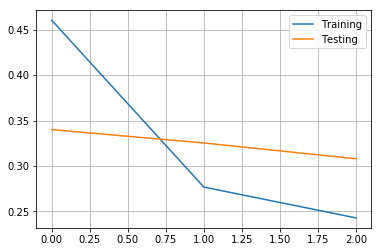

In [40]:
pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

## Evaluate model

The model reaches an accuracy of ~90% (either with the LSTM or the Flatten layer).

In [41]:
# Final evaluation of the model 
scores = model.evaluate(X_test, y_test, verbose=1) 

print("Accuracy: %.2f%%" % (scores[1]*100))

25000/25000 [==============================] - 63s 3ms/step
Accuracy: 87.36%


## Sentiment prediction

Here the model is used to predict a given review reflects that its author liked or disliked the movie. To do that, the input reviews must be translated into word embedding vectors that will be padded as in the training phase in order to be fed into the model.

In [37]:
bad = "this movie was terrible and bad"
good = "i really liked the movie and had fun"
for review in [good,bad]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length) 
    print("%s . Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

i really liked the movie and had fun . Sentiment: 0.86252767
this movie was terrible and bad . Sentiment: 0.092300415
